#### PGSI prediction with NN

In [1]:
import os
import findspark
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
import datetime as dt
import statistics
import pickle

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-1.8.0'
os.environ['PYSPARK_SUBMIT_ARGS']="--master yarn --deploy-mode client pyspark-shell"

findspark.init('/opt/mapr/spark/spark-2.3.1')
import pyspark

from pyspark.sql import SparkSession, HiveContext, SQLContext, Row
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, StructType, StructField
from pyspark.sql.window import Window

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense 
from tensorflow.keras import backend as K

spark = (SparkSession\
                .builder\
                .appName('PGSI_NN')\
                .enableHiveSupport()\
                .getOrCreate())

pd.set_option('display.max_rows', 50000000)
pd.set_option('display.max_columns', 500)

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Prepare data - Helper methods

In [2]:
def clean_agg_column(x, agg_type):
    ''' Returns a column name without the agg prefix
        e.g sum(foo) ==> foo
    
        Arguments: input string and prefix type eg. sum, mean etc
        Returns: modified string
    '''
    
    output = str.replace(x, agg_type + "(", "")
    output = str.replace(output, ")", "")

    return output

def get_train_test(main_data, size):
    '''
    Split training and testing, size is testing dataset size
    '''
    # split X and y
    X = main_data.drop(['account_no', 'pgsi_score'], axis=1)
    y = main_data[['pgsi_score']]
    
    # scale X for nn 
#     scaler_X = MinMaxScaler()
#     scaled_X = scaler_X.fit_transform(X)
    
    scaler_X = StandardScaler()
    scaled_X = scaler_X.fit_transform(X)
     
    train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=size, random_state=42)
    
    return train_X, test_X, train_Y, test_Y, scaler_X

#### Prepare data

In [3]:
# this code does not detail data preperation due to the sensitive nature of the data
main_data = spark.sql('SELECT * FROM analytics.pgsi_training_dat_1').toPandas() 

# modify column names
col_names = [clean_agg_column(col, 'avg') for col in main_data.columns]
main_data.columns = col_names

# testing dataset size is 0.3
train_X, test_X, train_Y, test_Y, scaler_X = get_train_test(main_data, 0.3)

#### Model - Helper methods 

In [4]:
def nn_loss(y_actual, y_prediction):
    '''
    Defines rmse as loss function for nn
    '''
    return K.sqrt(K.mean(K.square(y_actual - y_prediction)))

def rmse(model, test_X, test_Y):
    '''
    Caluclates rmse for recoded value
    '''
    y_actual, y_prediction, _ = get_actul_prediction(model, test_X, test_Y)
    return np.sqrt(mean_squared_error(y_actual, y_prediction))

def recode(x):
    '''
    Recodes pgsi_score 0-27 to 1-4
    '''
    output = 0
    
    if x < 1: output = 0
    elif x < 3: output = 1
    elif x < 8: output = 2
    else: output = 3
        
    return output

def get_actul_prediction(model, test_X, test_Y):
    '''
    Predict recode scores for test set
    '''
    predicted_y = model.predict(test_X)
    
    # recode
    predicted_df = pd.DataFrame(predicted_y, columns=['pgsi_prediction'])
    predicted_df['recode_prediction'] = predicted_df['pgsi_prediction'].apply(recode)
    
    actual_df = pd.DataFrame(test_Y, columns=['pgsi_score'])
    actual_df['recode_actual'] = actual_df['pgsi_score'].apply(recode)
    
    return actual_df.recode_actual, predicted_df.recode_prediction, predicted_df.pgsi_prediction

In [9]:
def get_model():
    '''
    Defines nn with 2 hidden layers 
    '''
    nn_model = Sequential()
    nn_model.add(Dense(8, input_dim=len(train_X.columns), kernel_initializer='normal', activation='sigmoid'))
    nn_model.add(Dense(4, activation='sigmoid'))
    nn_model.add(Dense(1, activation='linear'))
    nn_model.compile(loss=nn_loss, optimizer='adam')
    
    history = nn_model.fit(train_X, train_Y, epochs=1000, batch_size=150, validation_split=0.3, verbose=0)
    
    return nn_model, history

def model_pipeline(iterations):
    '''
    Finds best model from iterations
    '''
    max_acc = 0
    for it in range(iterations):
        nn_model, history = get_model()
        
        # testing accuracy
        y_actual_re, y_prediction_re, y_prediction = get_actul_prediction(nn_model, test_X, test_Y)
        y_actual_re.reset_index(drop=True, inplace=True)
        
        result = pd.concat([y_actual_re, y_prediction_re, y_prediction], axis=1)
        
        result2 = result[result.recode_actual > 0]
        acc = 1 - np.mean(np.abs((result2.recode_prediction - result2.recode_actual)/result2.recode_actual)) 
        
        # save stats of best model
        if acc > max_acc:
            max_acc = acc
            nn_model.save('nn_model_best') 
            
            nn_model_best = nn_model
            history_best = history
            result_best = result
            
            print(it)
            print('Training rmse: ', rmse(nn_model_best, train_X, train_Y))
            print('Testing rmse: ', rmse(nn_model_best, test_X, test_Y))
            print('Testing accuracy: ', max_acc)    

    return nn_model_best, history_best, result_best

#### Best model 

In [10]:
nn_model_best, history_best, result_best = model_pipeline(100)

0
Training rmse:  0.948351017982962
Testing rmse:  0.980910227263219
Testing accuracy:  0.6252525252525256
1
Training rmse:  0.935925625371442
Testing rmse:  0.9825152082557204
Testing accuracy:  0.6314574314574319
4
Training rmse:  0.9307397337863184
Testing rmse:  0.976617382911569
Testing accuracy:  0.642568542568543
5
Training rmse:  0.9289238907343956
Testing rmse:  0.967160358815365
Testing accuracy:  0.6505050505050507
17
Training rmse:  0.9284390661237428
Testing rmse:  0.958706236059213
Testing accuracy:  0.6920634920634923
76
Training rmse:  0.9335171663472106
Testing rmse:  0.9600748395198113
Testing accuracy:  0.6936507936507939


In [11]:
nn_model_best.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 8)                 304       
_________________________________________________________________
dense_232 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_233 (Dense)            (None, 1)                 5         
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


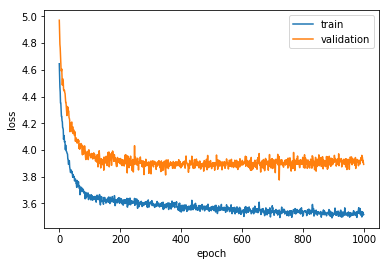

In [13]:
# plot sample train and validation loss - rmse is for pgsi scores
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Evaluation

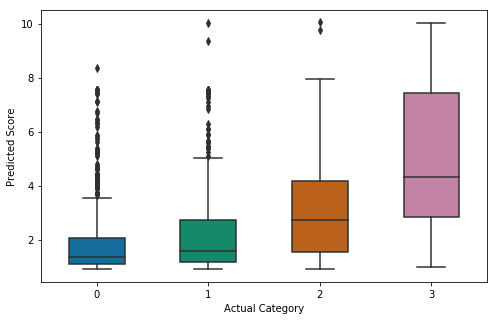

In [14]:
fig, ax = plt.subplots(figsize =(8, 5)) 
pl = sns.boxplot(y='pgsi_prediction', x='recode_actual', data=result_best, width=0.5, palette="colorblind")
pl.set_xlabel('Actual Category')
pl.set_ylabel('Predicted Score')
plt.show();